# **POTATO_Skin_Diseases_Detection_Using_Deep_Learning**

In [70]:
# %pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [71]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
Epochs = 50

In [72]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  #Directory containing the dataset
    shuffle=True,  #Shuffle the dataset
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #Resize images to 256x256 pixels
    batch_size=BATCH_SIZE  #Batch size for training
    )




Found 2152 files belonging to 3 classes.


1000+152+1000=2152 total images
#  **Dataset Structure**
```
PlantVillage/
├── Potato___Early_blight
│   ├── 0a1b2c3d.jpg
│   ├── 0a1b2c3e.jpg
│   └── ...
├── Potato___Late_blight
│   ├── 0a1b2c4d.jpg
│   ├── 0a1b2c4e.jpg
│   └── ...
└── Potato___healthy
    ├── 0a1b2c5d.jpg
    ├── 0a1b2c5e.jpg
    └── ...
```
#  **Dataset Information**
- **Total Images**: 2152
- **Classes**: 3 (Potato___Early_blight, Potato___Late_blight, Potato___healthy)
- **Image Size**: 256x256 pixels

3 Classes are the folder name

In [73]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [74]:
len(dataset)

68

In [75]:
68*32  # 2176 images in total last batch was not proper 
# 32 was Batch size

2176

**Explore data**

In [76]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0]


(32, 256, 256, 3)


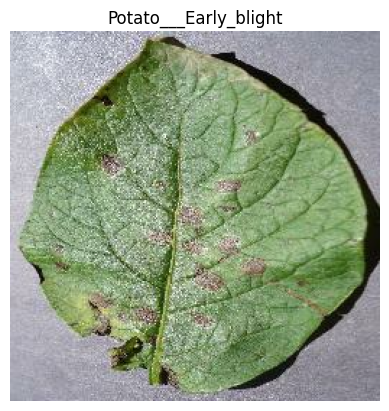

In [77]:
for image_batch, labels_batch in dataset.take(1):
    # print(image_batch[0]) # it will give image as a tensor
    # print(image_batch[0].numpy()) # it will give label as a numpy array
    print(image_batch.shape)  # (32, 256, 256, 3) 32 images of size 256x256 with 3 channels
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Display the first image
    plt.axis("off")  # Hide the axis
    plt.title(class_names[labels_batch[0]])  # Display the label of the first


# Display a batch of images


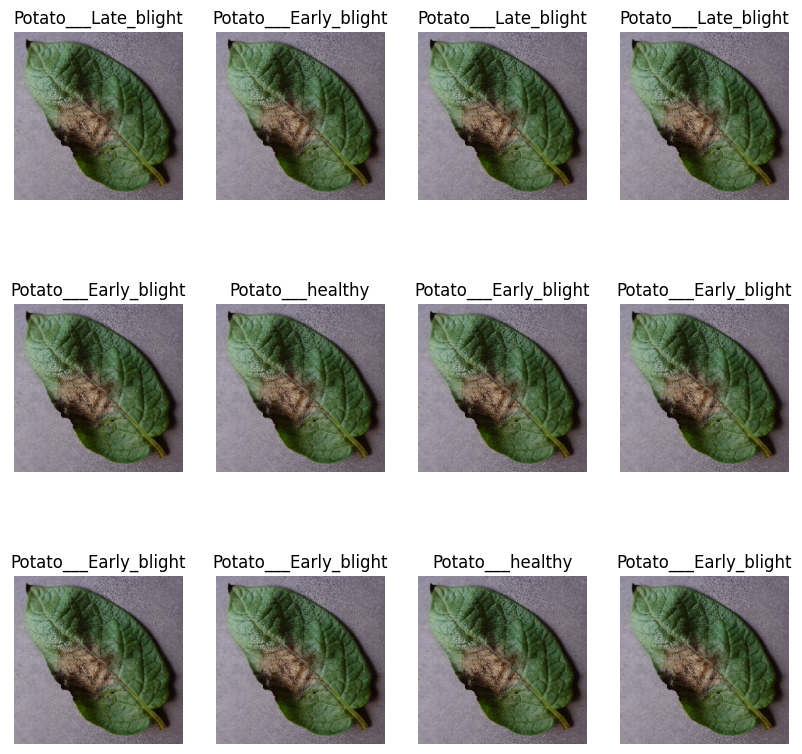

In [78]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))  
        plt.title(class_names[labels_batch[i]])  
        plt.axis("off")
        

# Split The dataset Into Test and Train

Validation and test datasets are 10% each, while the training dataset is 80%. With every epoch, the model will learn from the training dataset, validate its performance on the validation dataset, and finally test its accuracy on the test dataset.

After epoch we will use test dataset to check the accuracy of the model before the deploy.

**80% ==> training**

***20% ==> 10% ==> validation, 10% ==> test**

80% of 68

In [79]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [80]:
train_ds=dataset.take(54)  # 54 batches for training
len(train_ds)  # 54 batches for training

54

For test and validation we will use 10% each

In [81]:
test_ds=dataset.skip(54)  # Skip the first 54 batches for validtion and test
len(test_ds)  # 14 batches for validation and test

14

In [82]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [83]:
val_ds=test_ds.take(6)  # 6 batches for validation
len(val_ds)  # 6 batches for validation

6

In [84]:
test_ds=test_ds.skip(6)  # 6 batches for validation
len(test_ds)

8

# Function to Split Dataset into Train, Test and Validation

In [86]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=1000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

  
    return train_ds, val_ds, test_ds

In [87]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [88]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Caching

for second iteration we will use the same dataset, so we will cache it to speed up the process. Data is in main memory.

In [89]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Pre-Processing

# 1. scaling

In [93]:
# resize_and_rescale = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
    
# ])

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])


# DataAugmention 

for making model Robust

with diffferent angles, brightness, contrast, etc.

In [96]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

